<a href="https://colab.research.google.com/github/Utkarsha1a/DL_Projects/blob/main/Shoes_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal**: Given the images of a product with multiple categories, train a model which can classify the type of a product.

**Data Description**: Data is all about images of shoes with multiple categories and data is collected from a popular Ecommerce site. Data set consists of two folders train and test.

**Provided Files:**

**Train**: train set consists of images belonging to 3 different categories of shoes in 3 different folders: Boots, Sandals and Slippers.

**Test**: test set consists of images belonging to all 3 categories of shoes into a single folder.

**Instructions**:
1. Train set should be used to feed the model.
2. Test set should be used to predict labels for test data.

**Evaluation Criteria**: The evaluation metric for this problem statement is the Accuracy score
where each shoe category is matched with the actual shoe label.

### Mounts the google drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


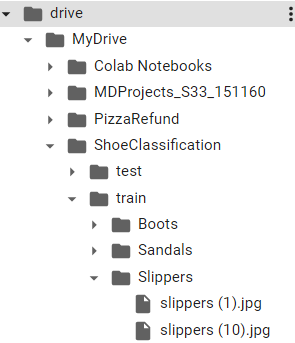

### Import Libraries

In [2]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

In [3]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf


### Create a Dataframe
The first step is to create a data frame that contains the filename and the corresponding labels column. For this, we will iterate over each image in the train folder and check the filename prefix.

In [5]:
direc = Path('/content/drive/MyDrive/ShoeClassification/train')
filepaths = list(direc.glob(r'*/*'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))


filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)

img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)


#Resampling it
img_df.tail()

,FilePaths,Labels
773,/content/drive/MyDrive/ShoeClassification/trai...,Slippers
774,/content/drive/MyDrive/ShoeClassification/trai...,Slippers
775,/content/drive/MyDrive/ShoeClassification/trai...,Slippers
776,/content/drive/MyDrive/ShoeClassification/trai...,Slippers
777,/content/drive/MyDrive/ShoeClassification/trai...,Slippers


##### Create a data frame of test folder with only filename

In [6]:
direc = Path('/content/drive/MyDrive/ShoeClassification/test')
filepaths = list(direc.glob(r'*'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))


filepaths = pd.Series(filepaths, name='FilePaths').astype(str)

img_test = pd.DataFrame(filepaths,columns=["FilePaths"])
img_test



,FilePaths
0,/content/drive/MyDrive/ShoeClassification/test...
1,/content/drive/MyDrive/ShoeClassification/test...
2,/content/drive/MyDrive/ShoeClassification/test...
3,/content/drive/MyDrive/ShoeClassification/test...
4,/content/drive/MyDrive/ShoeClassification/test...
...,...
84,/content/drive/MyDrive/ShoeClassification/test...
85,/content/drive/MyDrive/ShoeClassification/test...
86,/content/drive/MyDrive/ShoeClassification/test...
87,/content/drive/MyDrive/ShoeClassification/test...


#### Visualise the dataset

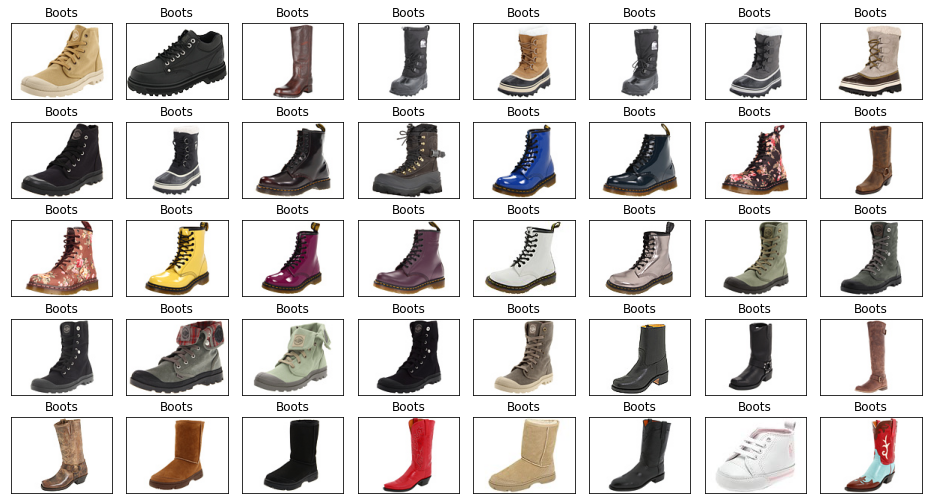

In [7]:
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=5, ncols=8,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

In [8]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 778 
 Count of Columns : 2 


In [9]:
img_df['Labels'].value_counts(ascending=True)

Slippers    146
Sandals     306
Boots       326
Name: Labels, dtype: int64

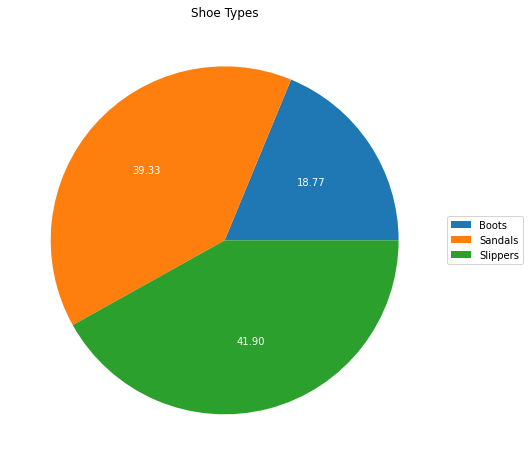

In [10]:
plt.figure(figsize=(10,8))
plt.pie(img_df['Labels'].value_counts(ascending=True), labels=img_df['Labels'].unique(),autopct='%1.2f',textprops=dict(color="w"))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Shoe Types")
plt.show()

#### Create Generators
Now, we will create the train and validation generator using the flow_from_dataframe method as

In [11]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
train_generator=datagen.flow_from_dataframe(
                dataframe=img_df,
                directory="/content/drive/MyDrive/ShoeClassification/train",
                x_col="FilePaths",
                y_col="Labels",
                subset="training",
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="categorical",
                target_size=(32,32))
valid_generator=datagen.flow_from_dataframe(
                dataframe=img_df,
                directory="/content/drive/MyDrive/ShoeClassification/train",
                x_col="FilePaths",
                y_col="Labels",
                subset="validation",
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="categorical",
                target_size=(32,32))
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
                                    dataframe=img_test,
                                    directory="/content/drive/MyDrive/ShoeClassification/test",
                                    x_col="FilePaths",
                                    y_col=None,
                                    batch_size=32,
                                    seed=42,
                                    shuffle=False,
                                    class_mode=None,
                                    target_size=(32,32))

Found 584 validated image filenames belonging to 3 classes.
Found 194 validated image filenames belonging to 3 classes.
Found 89 validated image filenames.


### Build the Model

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])

### Fitting the Model

In [13]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
18/18 [==============================] - 5s 87ms/step - loss: 0.5837 - accuracy: 0.5072 - val_loss: 0.6836 - val_accuracy: 0.0000e+00
Epoch 2/10
18/18 [==============================] - 1s 71ms/step - loss: 0.3750 - accuracy: 0.7283 - val_loss: 0.1431 - val_accuracy: 0.9167
Epoch 3/10
18/18 [==============================] - 1s 69ms/step - loss: 0.2937 - accuracy: 0.8062 - val_loss: 0.1213 - val_accuracy: 0.9323
Epoch 4/10
18/18 [==============================] - 1s 71ms/step - loss: 0.2578 - accuracy: 0.8641 - val_loss: 0.1647 - val_accuracy: 0.9115
Epoch 5/10
18/18 [==============================] - 1s 72ms/step - loss: 0.2071 - accuracy: 0.8822 - val_loss: 0.2617 - val_accuracy: 0.8646
Epoch 6/10
18/18 [==============================] - 1s 69ms/step - loss: 0.1803 - accuracy: 0.9076 - val_loss: 0.1935 - val_accuracy: 0.9062
Epoch 7/10
18/18 [==============================] - 1s 70ms/step - loss: 0.1691 - accuracy: 0.8913 - val_loss: 0.2589 - val_accuracy: 0.8854
Epoch 8/1

### Evaluate the model
Since we are evaluating the model, we should treat the validation set as if it was the test set. 

In [14]:
model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_TEST)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.06760438531637192, 0.984375]

### Predict the output

You need to reset the test_generator before whenever you call the predict_generator. This is important, if you forget to reset the test_generator you will get outputs in a weird order.

In [15]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


2/2 [==============================] - 0s 49ms/step


In [16]:
test_generator.filenames[0:10]

['/content/drive/MyDrive/ShoeClassification/test/image (53).jpg',
 '/content/drive/MyDrive/ShoeClassification/test/image (5).jpg',
 '/content/drive/MyDrive/ShoeClassification/test/image (50).jpg',
 '/content/drive/MyDrive/ShoeClassification/test/image (51).jpg',
 '/content/drive/MyDrive/ShoeClassification/test/image (54).jpg',
 '/content/drive/MyDrive/ShoeClassification/test/image (49).jpg',
 '/content/drive/MyDrive/ShoeClassification/test/image (55).jpg',
 '/content/drive/MyDrive/ShoeClassification/test/image (52).jpg',
 '/content/drive/MyDrive/ShoeClassification/test/image (48).jpg',
 '/content/drive/MyDrive/ShoeClassification/test/image (46).jpg']

In [17]:
predicted_class_indices=np.argmax(pred,axis=1)

predicted_class_indices has the predicted labels, but you can’t simply tell what the predictions are, because all you can see is numbers like 0,1,2…
and most importantly you need to map the predicted labels with their unique ids such as filenames to find out what you predicted for which image.

In [18]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [19]:
predictions[:10]

['Sandals',
 'Sandals',
 'Sandals',
 'Slippers',
 'Sandals',
 'Sandals',
 'Slippers',
 'Slippers',
 'Boots',
 'Boots']

### Visualise the test data

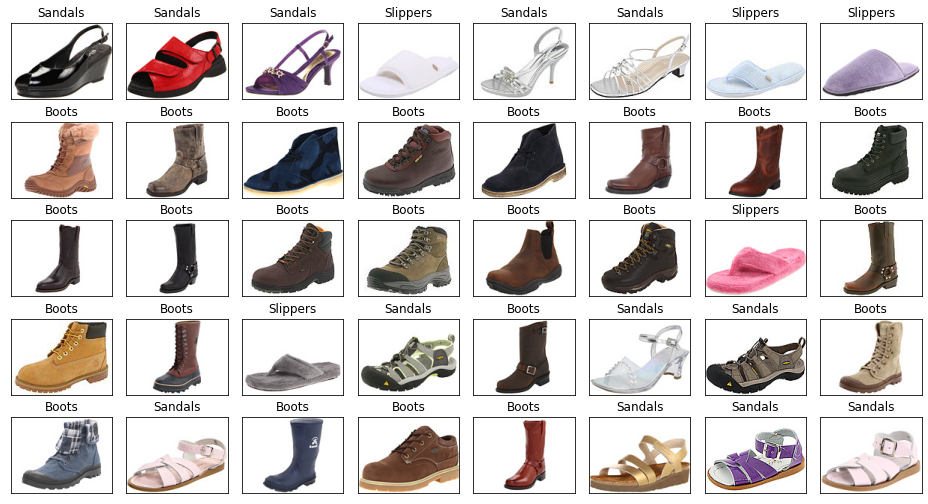

In [20]:
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=5, ncols=8,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(test_generator.filenames[i]))
    ax.set_title(predictions[i])
    
plt.tight_layout()
plt.show()